Add Robin boundary conditions.

Success!

Author: yanjun zhang

# ds needs define correct

## 1: Start

Source from 
book "Abali - 2017 - Computational Reality" P119

In [1]:
import pyvista
import ufl
import dolfinx
import time
import numpy as np
import matplotlib.pyplot as plt
from petsc4py import PETSc
from mpi4py import MPI
import sys

from dolfinx.fem.petsc import LinearProblem,assemble_vector, assemble_matrix, create_vector, apply_lifting, set_bc
from dolfinx import fem, mesh, io, plot, default_scalar_type, nls, log
from dolfinx.fem import (Constant, dirichletbc, Function, FunctionSpace, 
                         form,  locate_dofs_topological)
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import  locate_entities, locate_entities_boundary,meshtags
from ufl import (SpatialCoordinate, TestFunction, TrialFunction,
                 dx, grad, inner, Measure, dot, FacetNormal)

from dolfinx.fem.petsc import NonlinearProblem
from dolfinx.nls.petsc import NewtonSolver

from find_com_e import find_common_e

# Start time, Final time ,Time step
t = 0
Total_time = 1
num_steps  = 100
# time step size
dt = Total_time / num_steps  

# initial and brake pad temperature
Ti = 25
Tm = 25

# density (kg.m^-3), capacity (J/Kg.K), conductivity (W/m.K)
t_u = 1e3 # m to mm
rho = 7850 /(t_u**3)
c = 462
k = 48 / t_u

# mu, P_brake, v_angualr , r_disc , heat_distribution
mu = 0.35
P_brake = 246000
v_angualr = 48.3
r_disc = 0.25
heat_distribution = 0.88

# S_or is the original brake pad rubbing area, 200 cm2. 
S_or = 200
S_new = 200

# g is the heat source,unit is w/mm2
g = mu * P_brake * v_angualr * r_disc * heat_distribution *2 /(t_u**2)  * (S_or/S_new) *100
h = g/200  *0.0000001
radiation = 5.670*(10e-8)*0.5  *0.00000000000000001

print(v_angualr * r_disc * dt *1000)
print('heat flux g is ',g)
print('time step dt is ',dt)
print('radiation is ',radiation)

/home/yanjun/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


120.75
heat flux g is  182.97972
time step dt is  0.01
radiation is  2.835e-24


In [2]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__}   \
based on GIT commit:  \
{dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

DOLFINx version: 0.7.3   based on GIT commit:  ubuntu of https://github.com/FEniCS/dolfinx/


## 2: Mesh

In [3]:
# mesh
filename = "3-10" 
domain, cell_markers, facet_markers = gmshio.read_from_msh(filename+".msh", MPI.COMM_WORLD, 0, gdim=3)

# Define variational problem, Here Lagrange changes to CG, what is CG?
V = fem.FunctionSpace(domain, ('Lagrange', 1))

# initialization
def project(function, space):
    u = TrialFunction(space)
    v = TestFunction(space)
    a = inner(u, v) * dx
    L = inner(function, v) * dx
    problem = LinearProblem(a, L, bcs = [])
    return problem.solve()
    
# u_n is for initial condition and uh is the solver result.
# variable, need to be projected form Q onto V
Q = FunctionSpace(domain, ("DG", 0))
T_init = Function(Q)
T_init.name = "u_n"
T_init.x.array[:] = np.full_like(1, Ti, dtype=default_scalar_type)
u_n = project(T_init,V)
u_n.name = "u_n"

fdim = domain.topology.dim - 1
## bc_disc is zero, no any dirichlete boundary condition
bc_disc = mesh.locate_entities_boundary(
    domain, fdim , lambda x:  np.isclose(x[2], 50) )
bc = fem.dirichletbc(PETSc.ScalarType(Tm), fem.locate_dofs_topological(V, fdim, bc_disc), V)

Info    : Reading '3-10.msh'...
Info    : 168 entities
Info    : 10751 nodes
Info    : 43604 elements
Info    : Done reading '3-10.msh'


In [4]:
np.set_printoptions(threshold=np.inf)
print(type(PETSc.ScalarType(Tm)))
print(fem.locate_dofs_topological(V, fdim, bc_disc))
print(bc)

<class 'numpy.float64'>
[]


## 3: Setup output


In [5]:
xdmf = io.XDMFFile(domain.comm, "T4.xdmf", "w")
xdmf.write_mesh(domain)

boundaries = []
for i, (x_c, y_c) in enumerate(zip(x_co, y_co), start=1):
    vari_name = 10*i
    boundaries.append(  (vari_name, lambda x: (x[0]-x_c)**2 + (x[1]-y_c)**2  <= 324)  )

In [6]:
# Create boundary condition
import sys
sys.path.append('/home/yanjun/Documents/FEniCSx/Tutorial/Mesh/')
from rub_co import get_rub_coordinate
x_co, y_co = get_rub_coordinate()

boundary1= (10, lambda x: (x[0]-x_co[0])**2 + (x[1]-y_co[0])**2 <= 324)
boundary2= (20, lambda x: (x[0]-x_co[1])**2 + (x[1]-y_co[1])**2 <= 324) 
boundary3= (30, lambda x: (x[0]-x_co[2])**2 + (x[1]-y_co[2])**2 <= 324)
boundary4= (40, lambda x: (x[0]-x_co[3])**2 + (x[1]-y_co[3])**2 <= 324) 
boundary5= (50, lambda x: (x[0]-x_co[4])**2 + (x[1]-y_co[4])**2 <= 324)
boundary6= (60, lambda x: (x[0]-x_co[5])**2 + (x[1]-y_co[5])**2 <= 324) 
boundary7= (70, lambda x: (x[0]-x_co[6])**2 + (x[1]-y_co[6])**2 <= 324)
boundary8= (80, lambda x: (x[0]-x_co[7])**2 + (x[1]-y_co[7])**2 <= 324) 
boundary9= (90, lambda x: (x[0]-x_co[8])**2 + (x[1]-y_co[8])**2 <= 324)
boundary10= (100, lambda x: (x[0]-x_co[9])**2 + (x[1]-y_co[9])**2 <= 324) 
boundary11= (110, lambda x: (x[0]-x_co[10])**2 + (x[1]-y_co[10])**2 <= 324)
boundary12= (120, lambda x: (x[0]-x_co[11])**2 + (x[1]-y_co[11])**2 <= 324) 
boundary13= (130, lambda x: (x[0]-x_co[12])**2 + (x[1]-y_co[12])**2 <= 324)
boundary14= (140, lambda x: (x[0]-x_co[13])**2 + (x[1]-y_co[13])**2 <= 324) 
boundary15= (150, lambda x: (x[0]-x_co[14])**2 + (x[1]-y_co[14])**2 <= 324)
boundary16= (160, lambda x: (x[0]-x_co[15])**2 + (x[1]-y_co[15])**2 <= 324)
boundary17= (170, lambda x: (x[0]-x_co[16])**2 + (x[1]-y_co[16])**2 <= 324) 
boundary18= (180, lambda x: (x[0]-x_co[17])**2 + (x[1]-y_co[17])**2 <= 324)

boundaries1 = [boundary1,boundary2,boundary3,boundary4,boundary5,boundary6,boundary7,boundary8,boundary9,boundary10,
              boundary11,boundary12,boundary13,boundary14,boundary15,boundary16,boundary17,boundary18]
 
facet_indices1, facet_markers1 = [], [] 
fdim = domain.topology.dim - 1  
for (marker, locator) in boundaries1:
        facets = locate_entities(domain, fdim, locator)   
        facet_indices1.append(facets)
        facet_markers1.append(np.full_like(facets, marker))
facet_indices1 = np.hstack(facet_indices1).astype(np.int32)
facet_markers1 = np.hstack(facet_markers1).astype(np.int32)
            
A1 = facet_indices1
B = facet_markers1 
C = mesh.locate_entities_boundary(domain, fdim, lambda x: np.isclose(x[2], 20) )

common_indices1 = np.intersect1d(A1,C)
D = []
for index in common_indices1:
        rows_A1 = np.where(A1 == index)
        D.append( B[rows_A1] )
facet_markers1 = np.concatenate(D)
####################################

boundary20 = (200, lambda x:  x[2] == 20)
facet_indices2, facet_markers2 = [], [] 
fdim = domain.topology.dim - 1  
for (marker, locator) in [boundary20]:
        facets = locate_entities(domain, fdim, locator)   
        facet_indices2.append(facets)
        facet_markers2.append(np.full_like(facets, marker)) 
facet_indices2 = np.hstack(facet_indices2).astype(np.int32)
facet_markers2 = np.hstack(facet_markers2).astype(np.int32)

A1 = facet_indices2
B = facet_markers2
B1 = common_indices1
common_indices2 = np.setdiff1d(A1,B1)
D = []
for index in common_indices2:
        rows_A1 = np.where(A1 == index)
        D.append( B[rows_A1] )
facet_markers2 = np.concatenate(D) 
    
common_indices3 = [common_indices1,common_indices2]
facet_markers3 = [facet_markers1,facet_markers2]
common_indices3 = np.concatenate(common_indices3)
facet_markers3 = np.concatenate(facet_markers3)
sorted_indices3 = np.argsort(common_indices3)
      
facet_tag = meshtags(domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3])
ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 


In [7]:
#print(facet_markers1)
#print(facet_markers3)


## 4: Variational equation


In [12]:
uh = fem.Function(V)
uh.name = "uh"
uh = project(T_init,V)
xdmf.write_function(uh, t)

#u = ufl.TrialFunction(V)
uh = fem.Function(V)

v = ufl.TestFunction(V)
f = fem.Constant(domain, PETSc.ScalarType(0))
n_vector = FacetNormal(domain)

F = (rho*c)/dt*inner(uh,v)*dx + k*inner(grad(uh),grad(v))*dx+  h*inner(uh,v)*ds(200) + radiation*inner(uh**4,v) *ds(200) - ( inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx +  h * 25* v *ds(200) +  radiation * (25**4)* v *ds(200) )

#a = (rho*c)/dt*inner(u,v)*dx + k*inner(grad(u),grad(v))*dx+  h*inner(u,v)*ds(200) + radiation*inner(u**4,v) *ds(200)
#L = inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx +  h * 25* v *ds(200) +  radiation * (25**4)* v *ds(200)


for i in list(range(1,19)):
     F +=  - k * dot( grad(uh)* v, n_vector) *ds(10*i) - inner(g, v) *ds(10*i)

problem = NonlinearProblem(F, uh, bcs=[bc])

## 7: Using petsc4py to create a linear solver
solver = NewtonSolver(MPI.COMM_WORLD, problem)
solver.convergence_criterion = "incremental"
solver.rtol = 1e-6
solver.report = True

ksp = solver.krylov_solver
opts = PETSc.Options()
option_prefix = ksp.getOptionsPrefix()
opts[f"{option_prefix}ksp_type"] = "cg"
opts[f"{option_prefix}pc_type"] = "gamg"
opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
ksp.setFromOptions()

log.set_log_level(log.LogLevel.INFO)
n, converged = solver.solve(uh)
assert (converged)
print(f"Number of interations: {n:d}")


## 8:Visualization of time dependent problem using pyvista
import matplotlib as mpl
pyvista.start_xvfb()
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(V))
plotter = pyvista.Plotter()
plotter.open_gif("T4.gif", fps=30)
grid.point_data["Temperature"] = uh.x.array
warped = grid.warp_by_scalar("Temperature", factor=0)
viridis = mpl.colormaps.get_cmap("viridis").resampled(25)
sargs = dict(title_font_size=25, label_font_size=20,  color="black",
             position_x=0.1, position_y=0.8, width=0.8, height=0.1)
renderer = plotter.add_mesh(warped, show_edges=True, lighting=False,
                            cmap=viridis, scalar_bar_args=sargs,
                            #clim=[0, max(uh.x.array)])
                            clim=[0,  200])

2024-04-14 17:13:28.723 ( 831.486s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 17:13:28.814 ( 831.577s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 17:13:28.870 ( 831.633s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 17:13:28.871 ( 831.633s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 17:13:28.872 ( 831.635s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 17:13:28.872 ( 831.635s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 17:13:28.886 ( 831.649s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 17:13:28.886 ( 831.649s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 

Number of interations: 3


## 5: Solution


In [9]:
from rotation_co import rub_rotation
import numpy as np

degree = 10
total_degree = 0

for i in range(num_steps):
    t += dt
   
    boundaries1 = []
    x_co, y_co = rub_rotation (x_co, y_co, degree)   # update the location
    total_degree += degree  # Incrementing degree by 10 in each step
    
    sys.stdout.write('\r1: Rotation has applied for {} degree. '.format(total_degree))
    sys.stdout.write('2: Current time is ' + str(round(t,1)) + " s. ")
    sys.stdout.write('3: Completion is '  + str(round (100*(t/Total_time),1) )+ " %. ")
    sys.stdout.flush()
    
    boundary1= (10, lambda x: (x[0]-x_co[0])**2 + (x[1]-y_co[0])**2 <= 324)
    boundary2= (20, lambda x: (x[0]-x_co[1])**2 + (x[1]-y_co[1])**2 <= 324) 
    boundary3= (30, lambda x: (x[0]-x_co[2])**2 + (x[1]-y_co[2])**2 <= 324)
    boundary4= (40, lambda x: (x[0]-x_co[3])**2 + (x[1]-y_co[3])**2 <= 324) 
    boundary5= (50, lambda x: (x[0]-x_co[4])**2 + (x[1]-y_co[4])**2 <= 324)
    boundary6= (60, lambda x: (x[0]-x_co[5])**2 + (x[1]-y_co[5])**2 <= 324) 
    boundary7= (70, lambda x: (x[0]-x_co[6])**2 + (x[1]-y_co[6])**2 <= 324)
    boundary8= (80, lambda x: (x[0]-x_co[7])**2 + (x[1]-y_co[7])**2 <= 324) 
    boundary9= (90, lambda x: (x[0]-x_co[8])**2 + (x[1]-y_co[8])**2 <= 324)
    boundary10= (100, lambda x: (x[0]-x_co[9])**2 + (x[1]-y_co[9])**2 <= 324) 
    boundary11= (110, lambda x: (x[0]-x_co[10])**2 + (x[1]-y_co[10])**2 <= 324)
    boundary12= (120, lambda x: (x[0]-x_co[11])**2 + (x[1]-y_co[11])**2 <= 324) 
    boundary13= (130, lambda x: (x[0]-x_co[12])**2 + (x[1]-y_co[12])**2 <= 324)
    boundary14= (140, lambda x: (x[0]-x_co[13])**2 + (x[1]-y_co[13])**2 <= 324) 
    boundary15= (150, lambda x: (x[0]-x_co[14])**2 + (x[1]-y_co[14])**2 <= 324)
    boundary16= (160, lambda x: (x[0]-x_co[15])**2 + (x[1]-y_co[15])**2 <= 324)
    boundary17= (170, lambda x: (x[0]-x_co[16])**2 + (x[1]-y_co[16])**2 <= 324) 
    boundary18= (180, lambda x: (x[0]-x_co[17])**2 + (x[1]-y_co[17])**2 <= 324)
   
    boundaries1 = [boundary1,boundary2,boundary3,boundary4,boundary5,boundary6,boundary7,boundary8,boundary9,boundary10,
              boundary11,boundary12,boundary13,boundary14,boundary15,boundary16,boundary17,boundary18]
    #boundaries = boundaries+ [boundary19]
 
    facet_indices1, facet_markers1 = [], [] 
    fdim = domain.topology.dim - 1  
    for (marker, locator) in boundaries1:
        facets = locate_entities(domain, fdim, locator)   
        facet_indices1.append(facets)
        facet_markers1.append(np.full_like(facets, marker))  
    facet_indices1 = np.hstack(facet_indices1).astype(np.int32)
    facet_markers1 = np.hstack(facet_markers1).astype(np.int32)
    bc_disc = mesh.locate_entities_boundary( domain, fdim , lambda x:  np.isclose(x[2], 20) )        
    A1 = facet_indices1
    B = facet_markers1 
    C = bc_disc
    common_indices1 = np.intersect1d(A1,C)
    D = []
    for index in common_indices1:
        rows_A1 = np.where(A1 == index)
        D.append( B[rows_A1] )
    facet_markers1 = np.concatenate(D)
    ####################################

    
    boundary20 = (200, lambda x:  x[2] == 20)
    facet_indices2, facet_markers2 = [], [] 
    fdim = domain.topology.dim - 1  
    for (marker, locator) in [boundary20]:
        facets = locate_entities(domain, fdim, locator)   
        facet_indices2.append(facets)
        facet_markers2.append(np.full_like(facets, marker)) 
    facet_indices2 = np.hstack(facet_indices2).astype(np.int32)
    facet_markers2 = np.hstack(facet_markers2).astype(np.int32) 
    
    A1 = facet_indices2
    B = facet_markers2
    B1 = common_indices1
    common_indices2 = np.setdiff1d(A1,B1)
    D = []
    for index in common_indices2:
           rows_A1 = np.where(A1 == index)
           D.append( B[rows_A1] )
    facet_markers2 = np.concatenate(D) 
    
    common_indices3 = [common_indices1,common_indices2]
    facet_markers3 = [facet_markers1,facet_markers2]
    common_indices3 = np.concatenate(common_indices3)
    facet_markers3 = np.concatenate(facet_markers3)

    sorted_indices3 = np.argsort(common_indices3)
      
    facet_tag = meshtags(domain, fdim, common_indices3[sorted_indices3], facet_markers3[sorted_indices3])
    ds = Measure('ds', domain=domain, subdomain_data=facet_tag) 

    F = (rho*c)/dt*inner(uh,v)*dx + k*inner(grad(uh),grad(v))*dx+  h*inner(uh,v)*ds(200) + radiation*inner(uh**4,v) *ds(200) - ( inner(f,v) *dx + (rho*c)/dt * inner(u_n, v) * dx +  h * 25* v *ds(200) +  radiation * (25**4)* v *ds(200) )

    for i in list(range(1,19)):
         F +=  - k * dot( grad(uh)* v, n_vector) *ds(10*i) - inner(g, v) *ds(10*i)

    problem = NonlinearProblem(F, uh, bcs=[bc])

    ## 7: Using petsc4py to create a linear solver
    solver = NewtonSolver(MPI.COMM_WORLD, problem)
    solver.convergence_criterion = "incremental"
    solver.rtol = 1e-2
    
    ksp = solver.krylov_solver
    opts = PETSc.Options()
    option_prefix = ksp.getOptionsPrefix()
    opts[f"{option_prefix}ksp_type"] = "cg"
    opts[f"{option_prefix}pc_type"] = "gamg"
    opts[f"{option_prefix}pc_factor_mat_solver_type"] = "mumps"
    ksp.setFromOptions()

    
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array
    # Write solution to file
    xdmf.write_function(uh, t)
    # Update plot
    #warped = grid.warp_by_scalar("uh", factor=0)
    plotter.update_coordinates(warped.points.copy(), render=False)
    plotter.update_scalars(uh.x.array, render=False)
    plotter.write_frame()
    
plotter.close() 
xdmf.close()
print()


1: Rotation has applied for 10 degree. 2: Current time is 0.0 s. 3: Completion is 1.0 %. 

2024-04-14 16:59:41.559 (   4.322s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:41.560 (   4.323s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:41.560 (   4.323s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:41.561 (   4.324s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:41.561 (   4.324s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:41.561 (   4.324s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:41.561 (   4.324s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:41.561 (   4.324s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:41.561 (   4.324s) [mai

1: Rotation has applied for 30 degree. 2: Current time is 0.0 s. 3: Completion is 3.0 %. 

2024-04-14 16:59:41.902 (   4.665s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:41.903 (   4.666s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:41.903 (   4.666s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:41.903 (   4.666s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:41.904 (   4.667s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:41.904 (   4.667s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:41.904 (   4.667s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:41.905 (   4.668s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:41.905 (   4.668s) [mai

1: Rotation has applied for 50 degree. 2: Current time is 0.1 s. 3: Completion is 5.0 %. 

2024-04-14 16:59:42.120 (   4.884s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:42.121 (   4.884s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:42.122 (   4.885s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:42.123 (   4.885s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:42.131 (   4.894s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:42.151 (   4.914s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 16:59:42.152 (   4.915s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:42.234 (   4.997s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 60 degree. 2: Current time is 0.1 s. 3: Completion is 6.0 %. 

n            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:42.419 (   5.183s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:42.421 (   5.183s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:42.421 (   5.184s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:42.421 (   5.184s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:42.421 (   5.184s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:42.421 (   5.184s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:42.421 (   5.184s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:42.422 (   5.184s) [main            ]topologycomputation.cpp:77

1: Rotation has applied for 70 degree. 2: Current time is 0.1 s. 3: Completion is 7.0 %. 

2024-04-14 16:59:42.665 (   5.427s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:42.665 (   5.428s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:42.665 (   5.428s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:42.669 (   5.432s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:42.669 (   5.432s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:42.669 (   5.432s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:42.670 (   5.433s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:42.670 (   5.433s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:42.670 (   5.433s) [mai

1: Rotation has applied for 80 degree. 2: Current time is 0.1 s. 3: Completion is 8.0 %. 

2024-04-14 16:59:42.889 (   5.651s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:42.889 (   5.652s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:42.890 (   5.653s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:42.890 (   5.653s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:42.912 (   5.675s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:42.912 (   5.675s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:42.913 (   5.676s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:42.913 (   5.676s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:42.921 (   5.684s) [mai

1: Rotation has applied for 100 degree. 2: Current time is 0.1 s. 3: Completion is 10.0 %. 

2024-04-14 16:59:43.112 (   5.875s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:43.197 (   5.960s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:43.199 (   5.962s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:43.199 (   5.962s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:43.200 (   5.963s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:43.200 (   5.963s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:43.200 (   5.963s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:43.200 (   5.963s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:43.2

1: Rotation has applied for 110 degree. 2: Current time is 0.1 s. 3: Completion is 11.0 %. 

2024-04-14 16:59:43.426 (   6.189s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:43.426 (   6.189s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:43.429 (   6.191s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:43.429 (   6.191s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:43.442 (   6.205s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:43.442 (   6.205s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:43.445 (   6.208s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:43.445 (   6.208s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:43.451 (   6.214s) [mai

1: Rotation has applied for 130 degree. 2: Current time is 0.1 s. 3: Completion is 13.0 %. 

2024-04-14 16:59:43.662 (   6.425s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:43.742 (   6.505s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:43.743 (   6.506s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:43.743 (   6.506s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:43.743 (   6.506s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:43.743 (   6.506s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:43.743 (   6.506s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:43.744 (   6.507s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:43.7

1: Rotation has applied for 140 degree. 2: Current time is 0.1 s. 3: Completion is 14.0 %. 

2024-04-14 16:59:43.964 (   6.727s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:43.965 (   6.727s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:43.966 (   6.729s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:43.966 (   6.729s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:43.981 (   6.744s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:43.981 (   6.744s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:43.983 (   6.746s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:43.983 (   6.746s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:43.996 (   6.759s) [mai

1: Rotation has applied for 160 degree. 2: Current time is 0.2 s. 3: Completion is 16.0 %. 

2024-04-14 16:59:44.255 (   7.018s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:44.255 (   7.018s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:44.256 (   7.018s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:44.256 (   7.019s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:44.256 (   7.019s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:44.256 (   7.019s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:44.256 (   7.019s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:44.257 (   7.020s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:44.257 (   7.020s) [mai

1: Rotation has applied for 180 degree. 2: Current time is 0.2 s. 3: Completion is 18.0 %. 

2024-04-14 16:59:44.469 (   7.232s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:44.469 (   7.232s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:44.470 (   7.233s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:44.470 (   7.233s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:44.477 (   7.240s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:44.500 (   7.263s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 16:59:44.506 (   7.269s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:44.583 (   7.346s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 190 degree. 2: Current time is 0.2 s. 3: Completion is 19.0 %. 

2024-04-14 16:59:44.805 (   7.568s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:44.805 (   7.568s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:44.806 (   7.569s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:44.806 (   7.569s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:44.831 (   7.597s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:44.837 (   7.600s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:44.838 (   7.601s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:44.838 (   7.601s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:44.844 (   7.607s) [mai

1: Rotation has applied for 210 degree. 2: Current time is 0.2 s. 3: Completion is 21.0 %. 

2024-04-14 16:59:45.089 (   7.852s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:45.089 (   7.852s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:45.090 (   7.853s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:45.091 (   7.854s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:45.093 (   7.856s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:45.093 (   7.856s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:45.093 (   7.856s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:45.093 (   7.856s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:45.096 (   7.859s) [mai

1: Rotation has applied for 230 degree. 2: Current time is 0.2 s. 3: Completion is 23.0 %. 

2024-04-14 16:59:45.342 (   8.105s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:45.409 (   8.172s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:45.410 (   8.173s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:45.410 (   8.173s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:45.410 (   8.173s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:45.410 (   8.173s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:45.410 (   8.173s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:45.411 (   8.174s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:45.4

1: Rotation has applied for 240 degree. 2: Current time is 0.2 s. 3: Completion is 24.0 %. 

2024-04-14 16:59:45.625 (   8.388s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:45.625 (   8.388s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:45.627 (   8.390s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:45.627 (   8.390s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:45.647 (   8.410s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:45.649 (   8.413s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:45.651 (   8.414s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:45.651 (   8.414s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:45.662 (   8.424s) [mai

1: Rotation has applied for 260 degree. 2: Current time is 0.3 s. 3: Completion is 26.0 %. 

2024-04-14 16:59:45.800 (   8.563s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:45.800 (   8.563s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:45.805 (   8.568s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:45.822 (   8.585s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 16:59:45.823 (   8.586s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:45.881 (   8.644s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:45.882 (   8.645s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:45.882 (   8.645s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 

1: Rotation has applied for 270 degree. 2: Current time is 0.3 s. 3: Completion is 27.0 %. 

2024-04-14 16:59:46.092 (   8.855s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:46.092 (   8.855s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:46.093 (   8.856s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:46.093 (   8.856s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:46.108 (   8.871s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:46.108 (   8.871s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:46.109 (   8.872s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:46.109 (   8.872s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:46.115 (   8.878s) [mai

1: Rotation has applied for 290 degree. 2: Current time is 0.3 s. 3: Completion is 29.0 %. 

2024-04-14 16:59:46.365 (   9.128s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:46.366 (   9.129s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:46.366 (   9.129s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:46.366 (   9.129s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:46.366 (   9.129s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:46.366 (   9.129s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:46.367 (   9.130s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:46.367 (   9.130s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:46.367 (   9.130s) [mai

1: Rotation has applied for 300 degree. 2: Current time is 0.3 s. 3: Completion is 30.0 %. 

2024-04-14 16:59:46.577 (   9.340s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:46.577 (   9.340s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:46.593 (   9.356s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:46.593 (   9.356s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:46.594 (   9.357s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:46.594 (   9.357s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:46.599 (   9.363s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:46.626 (   9.389s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 16:59:46.627 (   9.

1: Rotation has applied for 320 degree. 2: Current time is 0.3 s. 3: Completion is 32.0 %. 

2024-04-14 16:59:46.773 (   9.536s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 16:59:46.774 (   9.537s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:46.838 (   9.601s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:46.839 (   9.602s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:46.839 (   9.602s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:46.840 (   9.602s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:46.840 (   9.603s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:46.840 (   9.603s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 

1: Rotation has applied for 330 degree. 2: Current time is 0.3 s. 3: Completion is 33.0 %. 

2024-04-14 16:59:47.077 (   9.840s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:47.077 (   9.840s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:47.078 (   9.841s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:47.078 (   9.841s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:47.095 (   9.858s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:47.095 (   9.858s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:47.096 (   9.859s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:47.097 (   9.859s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:47.102 (   9.865s) [mai

1: Rotation has applied for 350 degree. 2: Current time is 0.4 s. 3: Completion is 35.0 %. 

2024-04-14 16:59:47.334 (  10.097s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:47.336 (  10.099s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:47.336 (  10.099s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:47.336 (  10.099s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:47.336 (  10.099s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:47.336 (  10.099s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:47.337 (  10.100s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:47.337 (  10.100s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:47.337 (  10.100s) [mai

1: Rotation has applied for 360 degree. 2: Current time is 0.4 s. 3: Completion is 36.0 %. 

2024-04-14 16:59:47.559 (  10.322s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:47.559 (  10.322s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:47.562 (  10.325s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:47.562 (  10.325s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:47.575 (  10.339s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:47.576 (  10.339s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:47.577 (  10.340s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:47.577 (  10.340s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:47.597 (  10.360s) [mai

1: Rotation has applied for 380 degree. 2: Current time is 0.4 s. 3: Completion is 38.0 %. 

2024-04-14 16:59:47.828 (  10.591s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:47.828 (  10.591s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:47.828 (  10.591s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:47.828 (  10.591s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:47.829 (  10.592s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:47.829 (  10.592s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:47.829 (  10.592s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:47.829 (  10.592s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:47.829 (  10.592s) [mai

1: Rotation has applied for 390 degree. 2: Current time is 0.4 s. 3: Completion is 39.0 %. 

2024-04-14 16:59:48.040 (  10.803s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:48.040 (  10.803s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:48.041 (  10.804s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:48.041 (  10.804s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:48.054 (  10.817s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:48.054 (  10.817s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:48.056 (  10.819s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:48.056 (  10.819s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:48.068 (  10.831s) [mai

1: Rotation has applied for 410 degree. 2: Current time is 0.4 s. 3: Completion is 41.0 %. 

2024-04-14 16:59:48.302 (  11.065s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:48.306 (  11.068s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:48.306 (  11.069s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:48.306 (  11.069s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:48.306 (  11.069s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:48.306 (  11.069s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:48.307 (  11.069s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:48.307 (  11.070s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:48.307 (  11.070s) [mai

1: Rotation has applied for 420 degree. 2: Current time is 0.4 s. 3: Completion is 42.0 %. 

2024-04-14 16:59:48.500 (  11.263s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:48.500 (  11.263s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:48.501 (  11.264s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:48.501 (  11.264s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:48.514 (  11.277s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:48.514 (  11.277s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:48.515 (  11.278s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:48.516 (  11.278s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:48.520 (  11.283s) [mai

1: Rotation has applied for 440 degree. 2: Current time is 0.4 s. 3: Completion is 44.0 %. 

2024-04-14 16:59:48.748 (  11.511s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:48.749 (  11.511s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:48.749 (  11.512s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:48.749 (  11.512s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:48.750 (  11.513s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:48.750 (  11.513s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:48.750 (  11.513s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:48.751 (  11.514s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:48.751 (  11.514s) [mai

1: Rotation has applied for 460 degree. 2: Current time is 0.5 s. 3: Completion is 46.0 %. 

2024-04-14 16:59:48.954 (  11.717s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:48.954 (  11.717s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:48.956 (  11.719s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:48.956 (  11.719s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:48.963 (  11.726s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:48.983 (  11.746s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 16:59:48.984 (  11.747s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:49.048 (  11.811s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 470 degree. 2: Current time is 0.5 s. 3: Completion is 47.0 %. 

2024-04-14 16:59:49.241 (  12.004s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:49.241 (  12.004s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:49.242 (  12.005s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:49.242 (  12.005s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:49.254 (  12.017s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:49.254 (  12.017s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:49.256 (  12.019s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:49.256 (  12.019s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:49.266 (  12.029s) [mai

1: Rotation has applied for 490 degree. 2: Current time is 0.5 s. 3: Completion is 49.0 %. 

2024-04-14 16:59:49.480 (  12.242s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:49.480 (  12.243s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:49.480 (  12.243s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:49.480 (  12.243s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:49.480 (  12.243s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:49.480 (  12.243s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:49.481 (  12.244s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:49.481 (  12.244s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:49.481 (  12.244s) [mai

1: Rotation has applied for 510 degree. 2: Current time is 0.5 s. 3: Completion is 51.0 %. 

2024-04-14 16:59:49.686 (  12.449s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:49.696 (  12.465s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 16:59:49.704 (  12.467s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:49.757 (  12.520s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:49.760 (  12.522s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:49.760 (  12.523s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:49.760 (  12.523s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:49.760 (  12.523s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 530 degree. 2: Current time is 0.5 s. 3: Completion is 53.0 %. 

2024-04-14 16:59:49.945 (  12.708s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:49.945 (  12.708s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:49.946 (  12.709s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:49.946 (  12.709s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:49.961 (  12.724s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:49.961 (  12.724s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:49.962 (  12.725s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:49.962 (  12.725s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:49.966 (  12.729s) [mai

1: Rotation has applied for 540 degree. 2: Current time is 0.5 s. 3: Completion is 54.0 %. 

2024-04-14 16:59:50.235 (  12.998s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:50.235 (  12.998s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:50.236 (  13.000s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:50.237 (  13.000s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:50.251 (  13.015s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:50.252 (  13.015s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:50.254 (  13.017s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:50.254 (  13.017s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:50.261 (  13.024s) [mai

1: Rotation has applied for 560 degree. 2: Current time is 0.6 s. 3: Completion is 56.0 %. 

2024-04-14 16:59:50.413 (  13.176s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:50.470 (  13.233s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:50.472 (  13.235s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:50.472 (  13.235s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:50.472 (  13.235s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:50.473 (  13.236s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:50.473 (  13.236s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:50.474 (  13.236s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:50.4

1: Rotation has applied for 570 degree. 2: Current time is 0.6 s. 3: Completion is 57.0 %. 

2024-04-14 16:59:50.665 (  13.428s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:50.665 (  13.428s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:50.666 (  13.429s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:50.666 (  13.429s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:50.682 (  13.445s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:50.682 (  13.445s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:50.684 (  13.447s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:50.684 (  13.447s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:50.689 (  13.452s) [mai

1: Rotation has applied for 590 degree. 2: Current time is 0.6 s. 3: Completion is 59.0 %. 

2024-04-14 16:59:50.856 (  13.619s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:50.915 (  13.678s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:50.916 (  13.679s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:50.916 (  13.679s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:50.916 (  13.679s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:50.916 (  13.679s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:50.916 (  13.679s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:50.916 (  13.679s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:50.9

1: Rotation has applied for 600 degree. 2: Current time is 0.6 s. 3: Completion is 60.0 %. 

2024-04-14 16:59:51.122 (  13.885s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:51.122 (  13.885s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:51.123 (  13.886s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:51.123 (  13.886s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:51.133 (  13.896s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:51.150 (  13.913s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 16:59:51.153 (  13.916s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:51.207 (  13.970s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 620 degree. 2: Current time is 0.6 s. 3: Completion is 62.0 %. 

2024-04-14 16:59:51.296 (  14.058s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:51.355 (  14.118s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:51.355 (  14.118s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:51.355 (  14.118s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:51.355 (  14.118s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:51.356 (  14.119s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:51.356 (  14.119s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:51.356 (  14.119s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:51.3

1: Rotation has applied for 640 degree. 2: Current time is 0.6 s. 3: Completion is 64.0 %. 

2024-04-14 16:59:51.576 (  14.339s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:51.649 (  14.412s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:51.650 (  14.413s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:51.650 (  14.413s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:51.650 (  14.413s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:51.651 (  14.414s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:51.651 (  14.414s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:51.651 (  14.414s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:51.6

1: Rotation has applied for 650 degree. 2: Current time is 0.7 s. 3: Completion is 65.0 %. 

2024-04-14 16:59:51.858 (  14.621s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:51.858 (  14.621s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:51.859 (  14.622s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:51.859 (  14.622s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:51.865 (  14.628s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:51.881 (  14.644s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 16:59:51.882 (  14.645s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:51.941 (  14.704s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 670 degree. 2: Current time is 0.7 s. 3: Completion is 67.0 %. 

2024-04-14 16:59:52.100 (  14.863s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:52.101 (  14.864s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:52.101 (  14.864s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:52.101 (  14.864s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:52.101 (  14.864s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:52.101 (  14.864s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:52.102 (  14.865s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:52.102 (  14.865s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:52.102 (  14.865s) [mai

1: Rotation has applied for 680 degree. 2: Current time is 0.7 s. 3: Completion is 68.0 %. 

2024-04-14 16:59:52.302 (  15.065s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:52.302 (  15.065s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:52.303 (  15.066s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:52.303 (  15.066s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:52.316 (  15.079s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:52.317 (  15.079s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:52.318 (  15.081s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:52.318 (  15.081s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:52.324 (  15.086s) [mai

1: Rotation has applied for 700 degree. 2: Current time is 0.7 s. 3: Completion is 70.0 %. 

2024-04-14 16:59:52.572 (  15.335s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:52.572 (  15.335s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:52.572 (  15.335s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:52.572 (  15.335s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:52.573 (  15.336s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:52.573 (  15.336s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:52.573 (  15.336s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:52.573 (  15.336s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:52.573 (  15.336s) [mai

1: Rotation has applied for 710 degree. 2: Current time is 0.7 s. 3: Completion is 71.0 %. 

2024-04-14 16:59:52.767 (  15.532s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:52.769 (  15.532s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:52.770 (  15.533s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:52.770 (  15.533s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:52.786 (  15.549s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:52.786 (  15.549s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:52.787 (  15.550s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:52.787 (  15.550s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:52.792 (  15.555s) [mai

1: Rotation has applied for 730 degree. 2: Current time is 0.7 s. 3: Completion is 73.0 %. 

2024-04-14 16:59:53.005 (  15.768s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.005 (  15.768s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.005 (  15.768s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:53.006 (  15.769s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.006 (  15.769s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.006 (  15.769s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:53.006 (  15.769s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.006 (  15.769s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.006 (  15.769s) [mai

1: Rotation has applied for 750 degree. 2: Current time is 0.8 s. 3: Completion is 75.0 %. 

2024-04-14 16:59:53.256 (  16.019s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:53.327 (  16.090s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.330 (  16.093s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.330 (  16.093s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:53.330 (  16.093s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.330 (  16.093s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.330 (  16.093s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:53.330 (  16.093s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.3

1: Rotation has applied for 760 degree. 2: Current time is 0.8 s. 3: Completion is 76.0 %. 

2024-04-14 16:59:53.519 (  16.293s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:53.530 (  16.293s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:53.531 (  16.294s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:53.531 (  16.294s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:53.557 (  16.320s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:53.557 (  16.320s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:53.558 (  16.321s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:53.558 (  16.321s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:53.566 (  16.329s) [mai

1: Rotation has applied for 780 degree. 2: Current time is 0.8 s. 3: Completion is 78.0 %. 

2024-04-14 16:59:53.789 (  16.552s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.789 (  16.552s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.789 (  16.552s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:53.789 (  16.552s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.790 (  16.553s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.790 (  16.553s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:53.790 (  16.553s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.790 (  16.553s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:53.790 (  16.553s) [mai

1: Rotation has applied for 800 degree. 2: Current time is 0.8 s. 3: Completion is 80.0 %. 

2024-04-14 16:59:54.076 (  16.839s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:54.076 (  16.839s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:54.076 (  16.839s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:54.077 (  16.839s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:54.077 (  16.840s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:54.077 (  16.840s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:54.078 (  16.841s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:54.078 (  16.841s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:54.078 (  16.841s) [mai

1: Rotation has applied for 820 degree. 2: Current time is 0.8 s. 3: Completion is 82.0 %. 

2024-04-14 16:59:54.274 (  17.037s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:54.275 (  17.038s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:54.275 (  17.038s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:54.282 (  17.045s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:54.299 (  17.062s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 16:59:54.300 (  17.063s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:54.358 (  17.121s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:54.358 (  17.121s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 830 degree. 2: Current time is 0.8 s. 3: Completion is 83.0 %. 

2024-04-14 16:59:54.560 (  17.323s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:54.560 (  17.323s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:54.562 (  17.324s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:54.562 (  17.324s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:54.568 (  17.331s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:54.583 (  17.348s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 16:59:54.587 (  17.350s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:54.642 (  17.405s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 850 degree. 2: Current time is 0.9 s. 3: Completion is 85.0 %. 

2024-04-14 16:59:54.799 (  17.562s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:54.803 (  17.566s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:54.803 (  17.566s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:54.803 (  17.566s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:54.803 (  17.566s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:54.803 (  17.566s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:54.803 (  17.566s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:54.804 (  17.567s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:54.804 (  17.567s) [mai

1: Rotation has applied for 860 degree. 2: Current time is 0.9 s. 3: Completion is 86.0 %. 

2024-04-14 16:59:55.009 (  17.772s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:55.009 (  17.772s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:55.012 (  17.775s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:55.012 (  17.775s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:55.027 (  17.790s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:55.027 (  17.790s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:55.028 (  17.791s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:55.029 (  17.791s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:55.032 (  17.796s) [mai

1: Rotation has applied for 880 degree. 2: Current time is 0.9 s. 3: Completion is 88.0 %. 

2024-04-14 16:59:55.192 (  17.955s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:55.256 (  18.019s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:55.257 (  18.020s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:55.257 (  18.020s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:55.258 (  18.021s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:55.258 (  18.021s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:55.258 (  18.021s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:55.258 (  18.021s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:55.2

1: Rotation has applied for 890 degree. 2: Current time is 0.9 s. 3: Completion is 89.0 %. 

2024-04-14 16:59:55.456 (  18.219s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:55.460 (  18.223s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:55.461 (  18.224s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:55.461 (  18.224s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:55.472 (  18.235s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:55.472 (  18.235s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:55.473 (  18.236s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:55.473 (  18.236s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:55.478 (  18.241s) [mai

1: Rotation has applied for 910 degree. 2: Current time is 0.9 s. 3: Completion is 91.0 %. 

2024-04-14 16:59:55.634 (  18.397s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:55.703 (  18.466s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:55.705 (  18.468s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:55.705 (  18.468s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:55.705 (  18.468s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:55.706 (  18.469s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:55.706 (  18.469s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:55.706 (  18.469s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:55.7

1: Rotation has applied for 920 degree. 2: Current time is 0.9 s. 3: Completion is 92.0 %. 

2024-04-14 16:59:55.902 (  18.665s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:55.902 (  18.665s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:55.903 (  18.666s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:55.903 (  18.666s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:55.915 (  18.678s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:55.915 (  18.678s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:55.916 (  18.679s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:55.916 (  18.679s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:55.921 (  18.684s) [mai

1: Rotation has applied for 940 degree. 2: Current time is 0.9 s. 3: Completion is 94.0 %. 

2024-04-14 16:59:56.056 (  18.819s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:56.056 (  18.819s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:56.061 (  18.824s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:56.077 (  18.840s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 16:59:56.078 (  18.841s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:56.137 (  18.900s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:56.137 (  18.900s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:56.137 (  18.900s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 

1: Rotation has applied for 950 degree. 2: Current time is 1.0 s. 3: Completion is 95.0 %. 

2024-04-14 16:59:56.329 (  19.092s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:56.330 (  19.092s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:56.331 (  19.093s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:56.331 (  19.094s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:56.338 (  19.101s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:56.357 (  19.120s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2024-04-14 16:59:56.358 (  19.121s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:56.417 (  19.180s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 

1: Rotation has applied for 970 degree. 2: Current time is 1.0 s. 3: Completion is 97.0 %. 

2024-04-14 16:59:56.500 (  19.263s) [main            ]      xdmf_function.cpp:51    INFO| Adding function to node "/Xdmf/Domain/Grid/Grid"
2024-04-14 16:59:56.561 (  19.324s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:56.562 (  19.325s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:56.562 (  19.325s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:56.562 (  19.325s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:56.562 (  19.325s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:56.562 (  19.325s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:56.562 (  19.325s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:56.5

1: Rotation has applied for 980 degree. 2: Current time is 1.0 s. 3: Completion is 98.0 %. 

2024-04-14 16:59:56.752 (  19.518s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:56.755 (  19.518s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:56.761 (  19.524s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:56.761 (  19.524s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:56.779 (  19.542s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:56.779 (  19.542s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:56.780 (  19.543s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 3
2024-04-14 16:59:56.780 (  19.543s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 2
2024-04-14 16:59:56.785 (  19.548s) [mai

1: Rotation has applied for 1000 degree. 2: Current time is 1.0 s. 3: Completion is 100.0 %. 

2024-04-14 16:59:57.009 (  19.772s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:57.009 (  19.772s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:57.009 (  19.772s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:57.010 (  19.773s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:57.010 (  19.773s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:57.010 (  19.773s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 2 - 0
2024-04-14 16:59:57.010 (  19.773s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:57.011 (  19.774s) [main            ]topologycomputation.cpp:776   INFO| Requesting connectivity 3 - 0
2024-04-14 16:59:57.011 (  19.774s) [mai

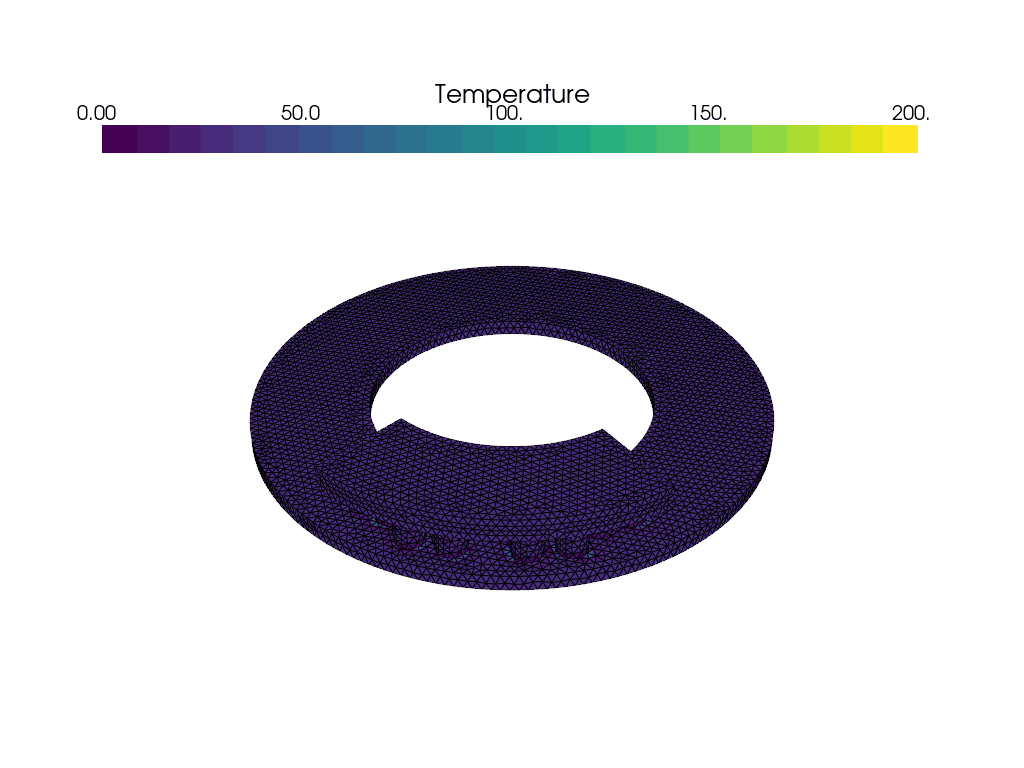

In [10]:
# Display the GIF
from IPython.display import display, Image
display(Image(filename = 'T4.gif'))